In [203]:
from IPython.display import display, Math

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
# from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = "dotted"
plt.rcParams["errorbar.capsize"] = 2
plt.rcParams["savefig.dpi"] = 200
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.02
plt.rcParams["savefig.format"] = "pdf"

from uncertainties import unumpy as unp
from uncertainties import ufloat
from uncertainties.unumpy import uarray
from uncertainties.unumpy import nominal_values as unominal
from uncertainties.unumpy import std_devs as ustdev

def ufloat_to_latex(uf, filename, var=None, dim=None, folder='tables'):
    res = ''
    if var is not None:
        res += var + '='
    res += f"{uf:L}"
    if dim is not None:
        res += ' \\ ' + dim
    with open(folder + '/' + filename, 'w') as f:
        print(res, file=f)
    display(Math(res))

In [204]:
g = ufloat(981, 1)
R = ufloat(83_144_626, 1)  # эрг/моль/К

T = ufloat(24.3 + 273.15, 0.1)  # К
P0 = ufloat(98.39, 0.01) * 1e3 * 10

V0 = ufloat(50, 1)
L = ufloat(10, 1)
r = ufloat(0.8, 0.1) / 2 /10
rho = ufloat(0.885, 0.001)

ufloat_to_latex(g, "g.tex", "g", "см/с^2")
ufloat_to_latex(R / 1e7, "R.tex", "R", "Дж/моль/К")
ufloat_to_latex(T, "T.tex", "T_{ком}", "К")
ufloat_to_latex(P0 / 1e4, "P.tex", "P_{атм}", "кПа")
ufloat_to_latex(rho, "rho.tex", r"\rho", "г/см^3")
ufloat_to_latex(V0, "V.tex", "V_{зап}", "см")
ufloat_to_latex(L, "L.tex", "L", "см")
ufloat_to_latex(r, "r.tex", "r", "см")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [205]:
dh1 = ufloat(34.7, 0.1) - ufloat(6.2, 0.1)
dh2 = ufloat(29.5, 0.1) - ufloat(11.3, 0.1)

P1 = rho * g * dh1
P2 = rho * g * dh2

Vf = P0 * V0 / P1
Vv = P0 * V0 * (P2 ** -1 - P1 ** -1)

ufloat_to_latex(dh1, "dh1.tex", "\Delta h_1", "см")
ufloat_to_latex(dh2, "dh2.tex", "\Delta h_2", "см")

ufloat_to_latex(Vf, "Vf.tex", "V_{фв}", "см")
ufloat_to_latex(Vv, "Vv.tex", "V_{вв}", "см")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

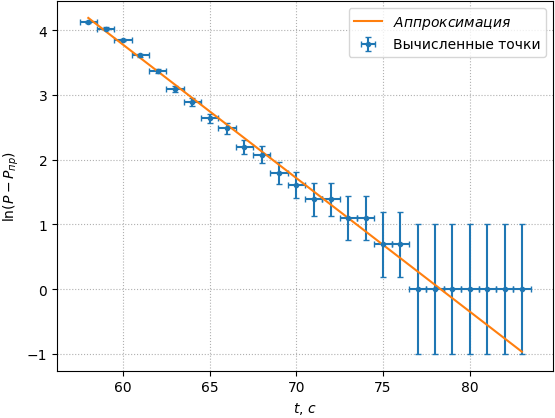

<IPython.core.display.Math object>

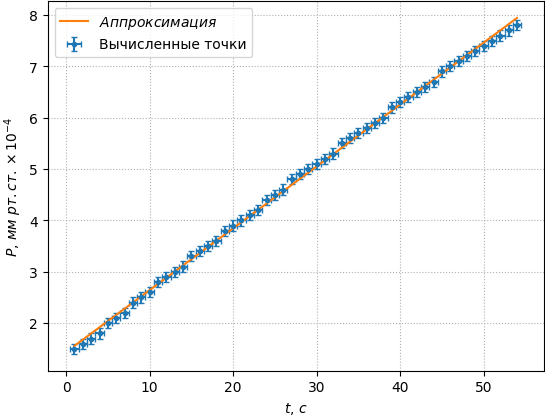

<IPython.core.display.Math object>

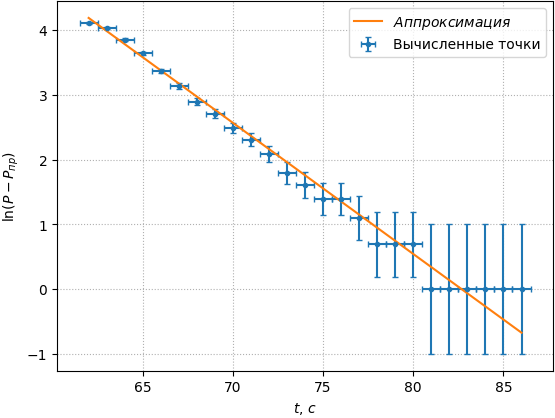

<IPython.core.display.Math object>

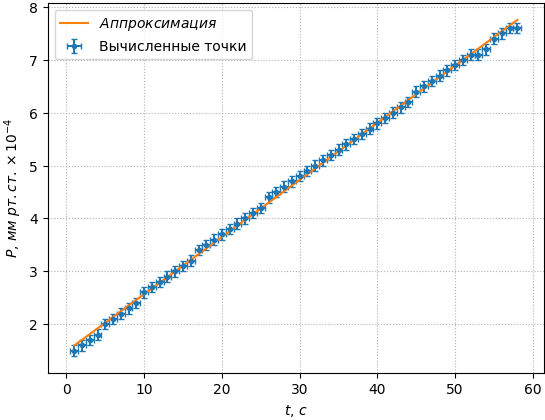

<IPython.core.display.Math object>

In [206]:
for n in [1, 2]:
    df = pd.read_csv(f"data/{n}.csv")

    df.rename(columns={"t (s)": "t", "h (mmHg*1e-5)": "h"}, inplace=True)
    df["t"] -= df["t"].min()
    df_rise, df_drop = df[:df["h"].argmax()], df[df["h"].argmax():]

    df_rise = df_rise[(df_rise["h"].min() < df_rise["h"]) & (df_rise["h"] < df_rise["h"].max())]

    df_drop = df_drop[(df_drop["h"].min() < df_drop["h"]) & (df_drop["h"] < df_drop["h"].max())]
    df_drop["h"] -= df["h"].min()

    df_rise["t"] = uarray(df_rise["t"], 0.5)
    df_rise["h"] = uarray(df_rise["h"], 1)
    df_drop["t"] = uarray(df_drop["t"], 0.5)
    df_drop["h"] = uarray(df_drop["h"], 1)

    # - - - - - - - - - - - - - - DROP - - - - - - - - - - - - - -

    plt.xlabel(r"$t$, $с$")
    plt.ylabel(r"$\ln(P-P_{пр})$")

    x_data_unp = df_drop["t"]
    y_data_unp = unp.log(df_drop["h"])

    x_data, x_err = unominal(x_data_unp), ustdev(x_data_unp)
    y_data, y_err = unominal(y_data_unp), ustdev(y_data_unp)

    plt.errorbar(x_data, y_data, xerr=x_err, yerr=y_err, fmt='.', label="Вычисленные точки")

    func = lambda x, a, b: a * x + b
    popt, pcov = curve_fit(func, x_data, y_data, sigma=y_err)
    perr = np.sqrt(np.diag(pcov))
    a = ufloat(popt[0], perr[0])
    b = ufloat(popt[1], perr[1])
    plt.plot(x_data, func(x_data, *popt), label=r"$Аппроксимация$")

    plt.legend()
    plt.savefig(f"images/drop{n}")
    plt.show()

    W = -a * Vv
    ufloat_to_latex(W, f"W{n}.tex", f"W_{{{n}}}", "см^3/c")

    # - - - - - - - - - - - - - - RISE - - - - - - - - - - - - - -

    plt.xlabel(r"$t$, $с$")
    plt.ylabel(r"$P$, $мм \ рт. ст. \times 10^{-4}$")

    x_data_unp = df_rise["t"]
    y_data_unp = df_rise["h"] / 10

    x_data, x_err = unominal(x_data_unp), ustdev(x_data_unp)
    y_data, y_err = unominal(y_data_unp), ustdev(y_data_unp)

    plt.errorbar(x_data, y_data, xerr=x_err, yerr=y_err, fmt='.', label="Вычисленные точки")

    func = lambda x, a, b: a * x + b
    popt, pcov = curve_fit(func, x_data, y_data, sigma=y_err)
    perr = np.sqrt(np.diag(pcov))
    a = ufloat(popt[0], perr[0])
    b = ufloat(popt[1], perr[1])
    plt.plot(x_data, func(x_data, *popt), label=r"$Аппроксимация$")

    plt.legend()
    plt.savefig(f"images/rise{n}")
    plt.show()

    h_lim = ufloat(df["h"].min(), 1) / 10
    Q_pump = 1e-4 * rho * g * (h_lim * W - a * Vv) / (R * T)
    ufloat_to_latex(Q_pump, f"Q{n}.tex", f"Q_н^{{{n}}}", "см^3/c")

In [207]:
M = ufloat(28.97, 0.01)

h_lim = ufloat(1.4e-4, 0.1e-4)
h_st = ufloat(2.5e-4, 0.1e-4)
h_fv = ufloat(4e-2, 0.1e-4)

P_lim = h_lim * rho * g
P_st = h_st * rho * g
P_fv = h_fv * rho * g

ufloat_to_latex(h_lim, "h_lim.tex", "h_{пр}", "см")
ufloat_to_latex(h_st, "h_st.tex", "h_{уст}", "см")
ufloat_to_latex(h_fv, "h_fv.tex", "h_{фв}", "см")

W = (4 / 3) * (r / L) * (2 * np.pi * R * T / M) ** 0.5 * r ** 2 * (P_fv - P_st) / (P_st - P_lim)
ufloat_to_latex(W, "W.tex", f"W", "см^3/c")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>